<a href="https://colab.research.google.com/github/Osilamajohn/Differential-Expression-Analysis-of-GSE18520-Dataset/blob/main/GSE18520.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#     **Differential Expression Analysis of GSE18520 Dataset**

[GSE18520](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE18520)

## **GSE18520: Whole-genome oligonucleotide expression analysis of papillary serous ovarian adenocarcinomas**

### **Organism**: Homo sapiens
### **Experiment Type**: Expression profiling by array

### **Summary**
### This study performed expression profiling on microdissected, late-stage, high-grade papillary serous ovarian adenocarcinomas to identify a prognostic gene signature that correlates with survival. The research aimed to uncover novel survival factors in ovarian cancer, a leading cause of cancer-related deaths among women. The study identified and validated a gene expression signature predictive of survival outcomes.

### **Study design**


* ### Tumor Samples: 53 advanced stage, high-grade primary tumor specimens
* ### Control Samples: 10 normal ovarian surface epithelium (OSE) brushings



### **Reference**
### Mok SC, Bonome T, Vathipadiekal V, Bell A et al. A gene signature predictive for outcome in advanced ovarian cancer identifies a survival factor: microfibril-associated glycoprotein 2. Cancer Cell, 2009, Dec 8;16(6):521-32. PMID: 19962670

## 1. Loading of Data

In [ ]:
gse18520_file = '/mnt/data/GSE18520_series_matrix.txt.gz'
gpl570_file = '/mnt/data/GPL570.annot.gz'

# Load the GSE18520 expression matrix and load the GPL570 annotation data
with gzip.open(gse18520_file, 'rt') as f:
    gse18520_data = pd.read_csv(f, sep="\t", comment="!", header=0, index_col=0)

with gzip.open(gpl570_file, 'rt') as f:
    gpl570_annotation = pd.read_csv(f, sep="\t", comment="#", skiprows=27)


## 2. Cleaning of the data, and merge the expression data with the gene annotations

In [ ]:
# Clean the annotation data + merge the expression data with the gene annotations
gpl570_clean = gpl570_annotation[['ID', 'Gene symbol']].dropna()

cleaned_gse18520_data = gse18520_data.merge(gpl570_clean, left_index=True, right_on='ID', how='left')

#Save the cleaned data to a CSV file
cleaned_gse18520_file = '/mnt/data/cleaned_gse18520_data.csv'
cleaned_gse18520_data.to_csv(cleaned_gse18520_file, index=False)

cleaned_gse18520_file

## 3. Set up the design matrix for the differential expression analysis

### 3.1 Load required libraries

In [1]:
# Install necessary packages if they are not already installed, and load the necessary libraries
if (!requireNamespace("BiocManager", quietly = TRUE)) install.packages("BiocManager")
BiocManager::install("limma")
if (!requireNamespace("ggplot2", quietly = TRUE)) install.packages("ggplot2")

library(limma)
library(ggplot2)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.19 (BiocManager 1.30.25), R 4.4.1 (2024-06-14)

Installing package(s) 'BiocVersion', 'limma'

also installing the dependency ‘statmod’


Old packages: 'httr2'



3.2 Differential expression analysis

In [2]:
cleaned_data <- read.csv("/content/cleaned_gse18520_data.csv")

# Extract the expression matrix (numeric columns) and assign rownames from 'ID'
expression_matrix <- as.matrix(cleaned_data[, 1:(ncol(cleaned_data) - 2)])

# Set rownames to Probe IDs
rownames(expression_matrix) <- cleaned_data$ID

# The design matrix
group <- factor(c(rep("Tumor", 53), rep("OSE", 10)))
design <- model.matrix(~0 + group)
colnames(design) <- levels(group)

# Fit the linear model and perform contrast fit for Tumor vs OSE
contrast_matrix <- makeContrasts(Tumor-OSE, levels=design)
fit <- lmFit(expression_matrix, design)
fit2 <- contrasts.fit(fit, contrast_matrix)
fit2 <- eBayes(fit2)


top_genes <- topTable(fit2, adjust = "BH", number = Inf)

# Convert rownames in top_genes to a column 'ID'
top_genes$ID <- rownames(top_genes)

# Merge with annotations
final_results <- merge(top_genes, cleaned_data[, c("ID", "Gene.symbol")], by = "ID")

# Find significant genes (logFC > 1 and P.Val < 0.05)
significant_genes <- final_results[abs(final_results$logFC) > 1 & final_results$adj.P.Val < 0.05, ]

# Find upregulated and downregulated genes
upregulated_genes <- nrow(significant_genes[significant_genes$logFC > 1, ])
downregulated_genes <- nrow(significant_genes[significant_genes$logFC < -1, ])
total_deg <- nrow(significant_genes)


geo_dataset <- "GSE18520"
total_samples <- ncol(expression_matrix)
affected_samples <- sum(group == "Tumor")
control_samples <- sum(group == "OSE")

summary_table <- data.frame(
  "GEO dataset" = geo_dataset,
  "Total sample" = total_samples,
  "Affected" = affected_samples,
  "Control" = control_samples,
  "Upregulated gene" = upregulated_genes,
  "Downregulated gene" = downregulated_genes,
  "Total DEG" = total_deg
)

print(summary_table)


write.csv(significant_genes, "GSE18520_final_results.csv", row.names = FALSE)
write.csv(summary_table, "GSE18520_summary_table.csv", row.names = FALSE)



  GEO.dataset Total.sample Affected Control Upregulated.gene Downregulated.gene
1    GSE18520           63       53      10            13690               9256
  Total.DEG
1     22946


## 4. Visualization of differentially expressed genes (DEGs)

,Gene.symbol,logFC,adj.P.Val
,<chr>,<dbl>,<dbl>
2,RFC2,-115.44128,9.298916e-03
4,PAX8,2238.13942,7.143820e-05
7,THRA,-55.53631,2.268903e-15
9,CCL5,-125.34134,4.152349e-02
12,ESRRA,536.76759,6.135659e-05
15,TTLL12,66.89745,3.733442e-02


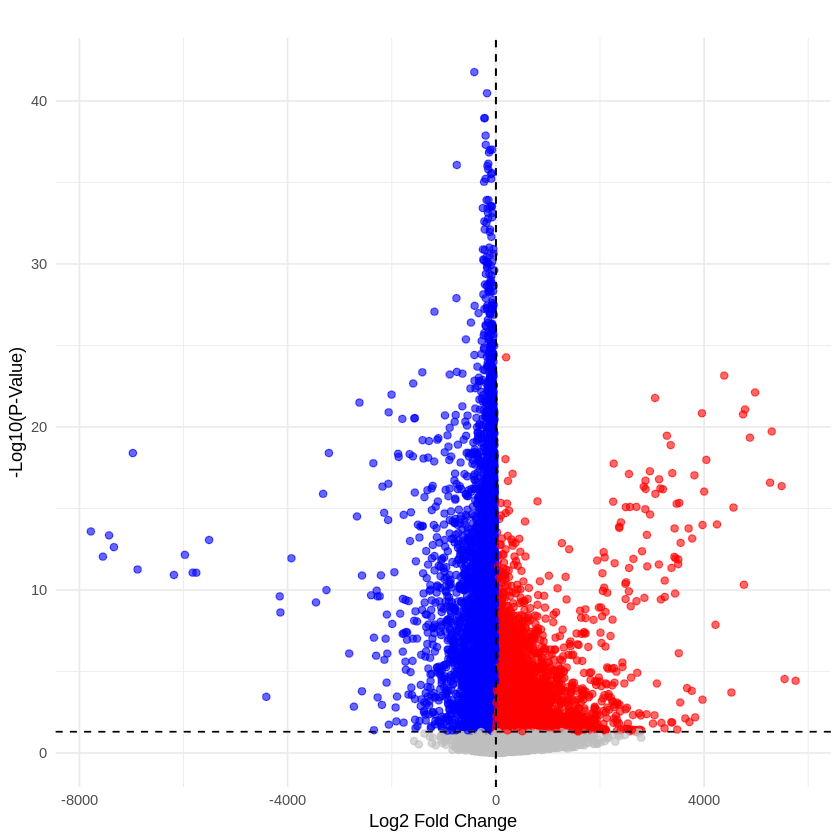

In [3]:
# Create a volcano plot
volcano_data <- final_results
volcano_data$Significance <- "Not Significant"
volcano_data$Significance[volcano_data$adj.P.Val < 0.05 & volcano_data$logFC > 1] <- "Upregulated"
volcano_data$Significance[volcano_data$adj.P.Val < 0.05 & volcano_data$logFC < -1] <- "Downregulated"

# Create the volcano plot
ggplot(volcano_data, aes(x = logFC, y = -log10(adj.P.Val), color = Significance)) +
  geom_point(alpha = 0.6, size = 1.75) +
  scale_color_manual(values = c("Downregulated" = "blue", "Not Significant" = "gray", "Upregulated" = "red")) +
  theme_minimal() +
  labs(title = "",
       x = "Log2 Fold Change",
       y = "-Log10(P-Value)") +
  theme(legend.position = "") +
  geom_hline(yintercept = -log10(0.05), linetype = "dashed", color = "black") +
  geom_vline(xintercept = c(-1, 1), linetype = "dashed", color = "black")

# Optionally, view the first few rows of the significant genes
head(significant_genes[, c("Gene.symbol", "logFC", "adj.P.Val")])
